Importing dependencies

In [1]:
import numpy as np
import tensorflow as tf
from keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt

Constants

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 100
CHANNELS=3
EPOCHS=50

### Data Collection

Import data into tensorflow dataset object

In [86]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    seed=100,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2985 files belonging to 5 classes.


### Exploratory Data Analysis (EDA) 

In [87]:
class_names = dataset.class_names
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 5
Class names: ['acne', 'cyst_tumor_tags', 'melanoma', 'monkeypox', 'normal']


In [88]:
from collections import Counter

class_counts = Counter()
for images, labels in dataset:
  class_counts.update(labels.numpy())

#images per class
for class_name, count in class_counts.items():
  print(f"{class_name, class_names[class_name]}: {count} images")


(0, 'acne'): 390 images
(2, 'melanoma'): 600 images
(3, 'monkeypox'): 700 images
(4, 'normal'): 700 images
(1, 'cyst_tumor_tags'): 595 images


In [106]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch)

(64, 100, 100, 3)
tf.Tensor(
[4 4 2 4 3 4 4 2 0 3 2 4 2 2 2 3 1 3 0 3 3 2 2 1 2 2 3 3 0 3 3 1 4 0 4 1 3
 3 3 2 4 4 3 3 4 3 1 4 3 0 3 3 1 3 1 3 3 3 3 3 1 2 1 0], shape=(64,), dtype=int32)


First image as a Tensor

In [96]:
image_batch[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[ 30.005   ,  21.005   ,  26.005   ],
        [ 29.015   ,  20.015   ,  25.015   ],
        [ 28.025   ,  19.025   ,  24.025   ],
        ...,
        [132.31001 ,  74.31001 ,  50.310013],
        [130.71501 ,  74.71501 ,  51.715015],
        [131.33499 ,  74.345   ,  54.34    ]],

       [[ 30.005   ,  21.005   ,  26.005   ],
        [ 29.015   ,  20.015   ,  25.015   ],
        [ 28.025   ,  19.025   ,  24.025   ],
        ...,
        [139.95001 ,  81.95001 ,  57.950012],
        [138.01501 ,  82.015015,  59.015015],
        [131.995   ,  75.005005,  55.      ]],

       [[ 30.005   ,  21.005   ,  26.005   ],
        [ 29.015   ,  20.015   ,  25.015   ],
        [ 28.025   ,  19.025   ,  24.025   ],
        ...,
        [137.85    ,  79.85001 ,  55.850014],
        [135.91501 ,  79.915016,  56.915016],
        [132.69499 ,  75.705   ,  55.7     ]],

       ...,

       [[ 32.995   ,  23.995   ,  26.995   ],
        [ 33.

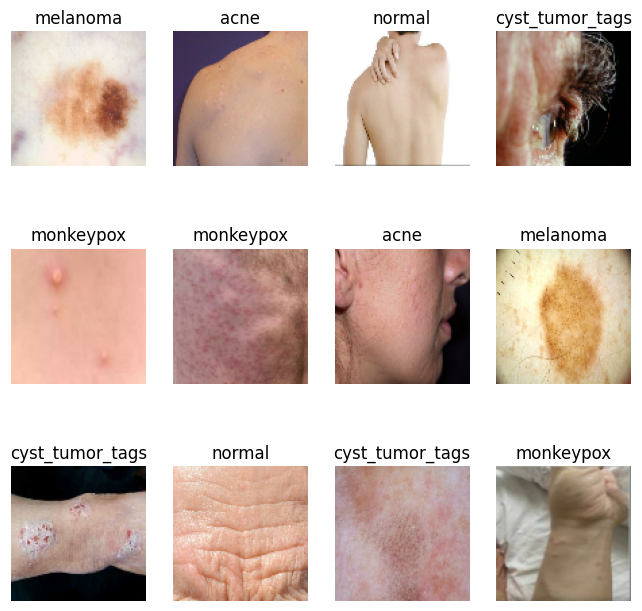

In [261]:
plt.figure(figsize=(8, 8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Data Preparation and Pre-processing

Handling with unbalanced data

In [ ]:
def augment(image, label):
  # Apply a random horizontal flip to the image with probability 0.5
  image = tf.image.random_flip_left_right(image)
  
  return image, label

# Oversample the class samples by applying the augment function
dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


<b>  Train test Split</b>

Training (80%): Dataset to be used while training

Validation (10%): Dataset to be tested against while training

Test (10%): Dataset to be tested against after we trained a model

In [344]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=100)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [345]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Train set

In [153]:
len(train_ds)

37

Validation set

In [10]:
len(val_ds)

4

Test set

In [11]:
len(test_ds)

6

Improving performance using Cache, Shuffle, and Prefetch

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Preprocessing by Resizing and Rescaling

In [13]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


Image augmentation (Flipping and Rotation)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [173]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Handling overfitting

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

### Model training

CNN model

In [23]:
#another approch
# from keras.applications import InceptionV3

# pretrained_base = InceptionV3()

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,

    layers.BatchNormalization(),
    layers.Conv2D(filters=50, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(.25), #reduce noise

    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.Dense(5, activation='softmax')
])


model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 100, 100, 3)         0         
                                                                 
 batch_normalization (BatchN  (64, 100, 100, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (64, 98, 98, 50)          1400      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 49, 49, 50)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (64, 49, 49, 50)          0         
                                                                 
 flatten (Flatten)           (64, 120050)             

Compiling the CNN model

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, epochs=50, callbacks=[early_stopping])

Epoch 1/50
37/37 [==============================] - 17s 447ms/step - loss: 3.2746 - accuracy: 0.4060 - val_loss: 1.4958 - val_accuracy: 0.2891
Epoch 2/50
37/37 [==============================] - 16s 445ms/step - loss: 1.1773 - accuracy: 0.4635 - val_loss: 1.4354 - val_accuracy: 0.3203
Epoch 3/50
37/37 [==============================] - 16s 444ms/step - loss: 1.0919 - accuracy: 0.5122 - val_loss: 1.2699 - val_accuracy: 0.4375
Epoch 4/50
37/37 [==============================] - 16s 440ms/step - loss: 1.0441 - accuracy: 0.5582 - val_loss: 1.1640 - val_accuracy: 0.5352
Epoch 5/50
37/37 [==============================] - 16s 437ms/step - loss: 1.0013 - accuracy: 0.5727 - val_loss: 1.0815 - val_accuracy: 0.5820
Epoch 6/50
37/37 [==============================] - 16s 444ms/step - loss: 0.9918 - accuracy: 0.5765 - val_loss: 1.0254 - val_accuracy: 0.6172
Epoch 7/50
37/37 [==============================] - 17s 446ms/step - loss: 0.9661 - accuracy: 0.5974 - val_loss: 0.9666 - val_accuracy: 0.6289

### Testing and Evaluation

In [26]:
model.evaluate(test_ds)

6/6 [==============================] - 1s 107ms/step - loss: 0.5667 - accuracy: 0.7734


[0.5667303204536438, 0.7734375]

Saving the model

In [27]:
# Save the model
model.save('model.h5')

Predicting on a sample image

First image to predict
Actual label: cyst_tumor_tags
2/2 [==============================] - 0s 37ms/step
Predicted label: cyst_tumor_tags


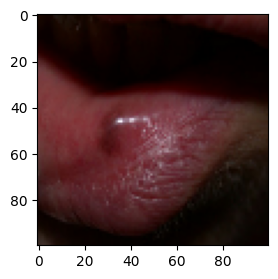

In [366]:
model = tf.keras.models.load_model('model.h5')

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.figure(figsize=(3, 3))
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

Evaluations

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Accuracy plot and Loss plot

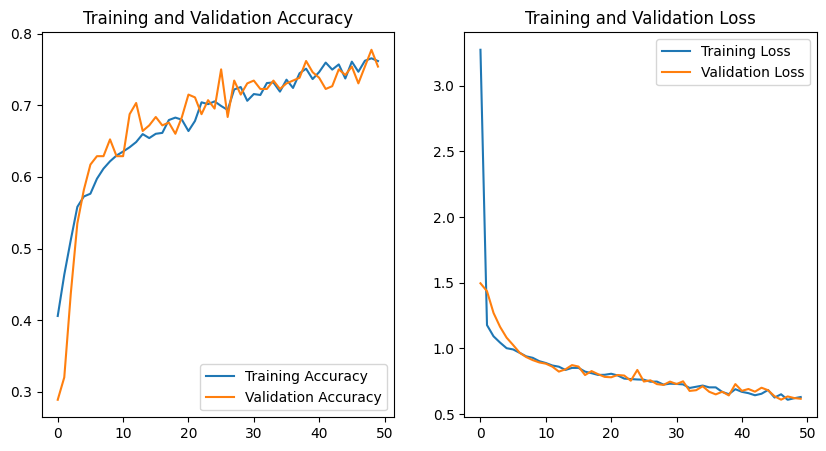

In [33]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Prediction for test dataset

In [362]:
for images_batch, labels_batch in test_ds:    
    prediction = model.predict(images_batch)

y_pred_classes = [np.argmax(i) for i in prediction]
y_pred_classes[:5]

2/2 [==============================] - 0s 38ms/step


[4, 4, 4, 4, 1]

Classification report

In [363]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(labels_batch, y_pred_classes, target_names=class_names))

                 precision    recall  f1-score   support

           acne       0.78      0.70      0.74        10
cyst_tumor_tags       0.50      0.58      0.54        12
       melanoma       1.00      0.90      0.95        10
      monkeypox       0.79      0.61      0.69        18
         normal       0.78      1.00      0.88        14

       accuracy                           0.75        64
      macro avg       0.77      0.76      0.76        64
   weighted avg       0.76      0.75      0.75        64



Confusion Matrix

Text(33.22222222222222, 0.5, 'Truth')

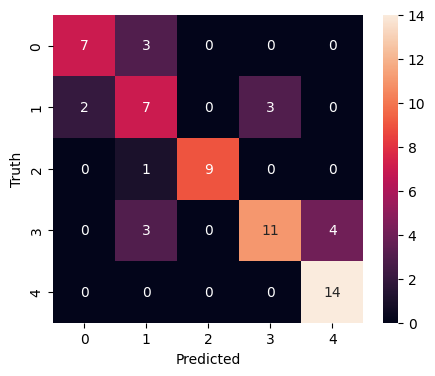

In [364]:
import seaborn as sn
cm = confusion_matrix(labels_batch, y_pred_classes)

plt.figure(figsize = (5,4))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Visual saliency map

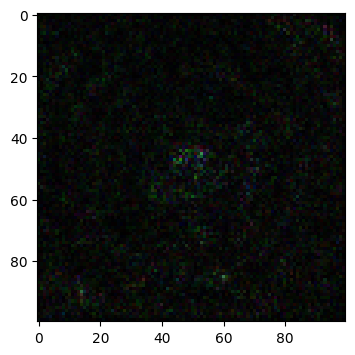

In [21]:
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')

# Load a image and label
image, label = next(iter(test_ds))

# Compute the saliency map for the image
with tf.GradientTape() as tape:
  tape.watch(image)
  logits = model(image)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label))
grad = tape.gradient(loss, image)
saliency = tf.abs(grad)

# Normalize the saliency map
saliency = tf.math.divide(saliency, tf.reduce_max(saliency))

saliency = saliency[0]
plt.figure(figsize=(4,4))
plt.imshow(saliency, cmap='gray')
plt.show()


 #### Practical solution for minimizing confusion arising in classification (Question 6)
In a situation where two classes are easily confused by the model, one approach you can take is to collect and annotate more data for these classes to improve the model's accuracy. By increasing the size and diversity of the training dataset for these classes, you can give the model more examples to learn from and improve its ability to distinguish between them by using techniques like data augmentation or class balancing to help the model generalize better to unseen examples and reduce the confusion between the two classes.
 